# Death to Cluster Models; Long Live Context Encoders

Modeling allows us to estimate useful parameters from data while ignoring noise, and then interpret these parameters as general mechanisms in complex systems. Traditional approaches to parameter estimation break down when true parameters vary continuously from sample to sample, which is often the case in biological systems. Our framework remedies this by estimating N models for N samples simultaneously, sharing information between each estimation task. We do this by learning to estimate parameters as a function of sample context, combining modern deep learning with classic statistical inference.


Outline of this demo:
- Linear Models: population vs. cluster vs. contextualized models, compared on prediction mean squared error (MSE) and parameter MSE
- Graphical Models: population vs. cluster vs. contextualized models, compared on prediction MSE and parameter MSE



## Section 1: Regression Models

### 1.1: Problem Overview
Say we have a dataset of patients with a disease, where we've measured each patient's response to treatments A and B under an uninformed (randomized) dosing of each treatment, as well as their risk factors (diet, exercise). We know that diet and exercise have some effect on response to treatment, but it isn't a simple or obvious relationship. Formally, we'll define this as a linear model with context-varying parameters:

```
Context:            C0, C1 ~ Uniform[-1, 1]
Treatment dose:     X0, X1 ~ Uniform[-1, 1]
Treatment effect:   W0 = C0 + C1^2, W1 = C0^2 + C1
Treatment response: Y = (X0 W0) + (X1 W1)
```

We want to estimate the treatment effect $\hat{W}$ based on observations $C, X, Y$.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
# Generate our data and do some plotting
n_z = 75
Z_space = np.linspace(-1, 1, n_z)
Z = np.zeros((n_z**2, 2))
for i, z_i in enumerate(Z_space):
    for j, z_j in enumerate(Z_space):
        Z[i * n_z + j] = [z_i, z_j]
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()
C = C[::-1]

W = np.zeros_like(Z_labels)
W[:,0] = C[:,0] + C[:,1]**2 
W[:,1] = C[:,0]**2 + C[:,1] 
W = np.repeat(W, z_samples, axis=0)
# W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
# Y += np.random.normal(0, .1, Y.shape)

def get_gaps(Z):
    dist = lambda a, b: np.sqrt(np.sum((a - b)**2)) 
    gap_centers = np.array([
        [0, 0],
        [.5, .5],
        [.5, -.5],
        [-.5, .5],
        [-.5, -.5],
    ])
    gap_radius = .1
    gap_idx = np.ones(len(Z))
    for i, z in enumerate(Z):
        for gap_center in gap_centers:
            if dist(z, gap_center) < gap_radius:
                gap_idx[i] = 0
    return gap_idx
    
    
gap_idx = get_gaps(Z_labels)
train_idx, test_idx = gap_idx == 0, gap_idx == 1
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train_pre, C_test_pre = split(C)
C_mean, C_std = C_train_pre.mean(axis=0), C_train_pre.std(axis=0)
C_train = (C_train_pre - C_mean) / C_std
C_test = (C_test_pre - C_mean) / C_std
W_train, W_test = split(W)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

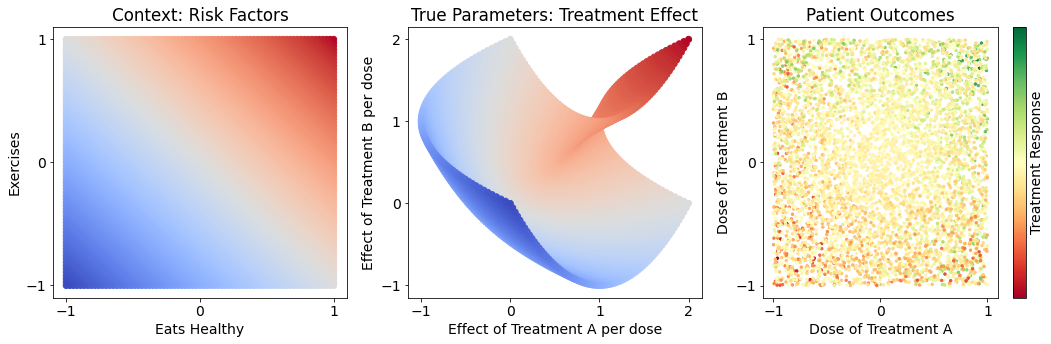

In [3]:
# Preliminary Exploration and Plotting
def cbar(arr):
    c = (arr - arr.mean()) / arr.std()
    return c

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0]

# Plot the context and treatment effect spaces
axs[0].scatter(C[:,0], C[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')

axs[1].scatter(W[:,0], W[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')

cplot = axs[2].scatter(X[:,0], X[:,1], c=cbar(Y), s=6., cmap='RdYlGn')
axs[2].set_xlabel('Dose of Treatment A')
axs[2].set_xticks([-1, 0, 1])
axs[2].set_ylabel('Dose of Treatment B')
axs[2].set_yticks([-1, 0, 1])
axs[2].set_title('Patient Outcomes')
plt.colorbar(cplot, ax=axs[2], ticks=[], label='Treatment Response')
plt.tight_layout()
plt.show()

### 1.2: Initial Thoughts

Notice that the patient outcomes seem noisy, but there is no noise in the sample generation. 
The variance of patient responses is due to meaningful variation in each patient's model parameters.
We never observe true parameters in real life, so it's easy to attribute variation to meaningless noise.
Here, we won't have that luxury: we'll compare all of our estimates against the true parameters to see how different estimators can generalize over the whole space.

### 1.3 Realistic Constraints

Let's say our dataset only contains highly localized populations of samples but we need to generalize to a much broader population. 
Below, we visualize the observed and unobserved populations, and pick two patients of interest to see how different methods generalize near observed populations and far away from observed populations.

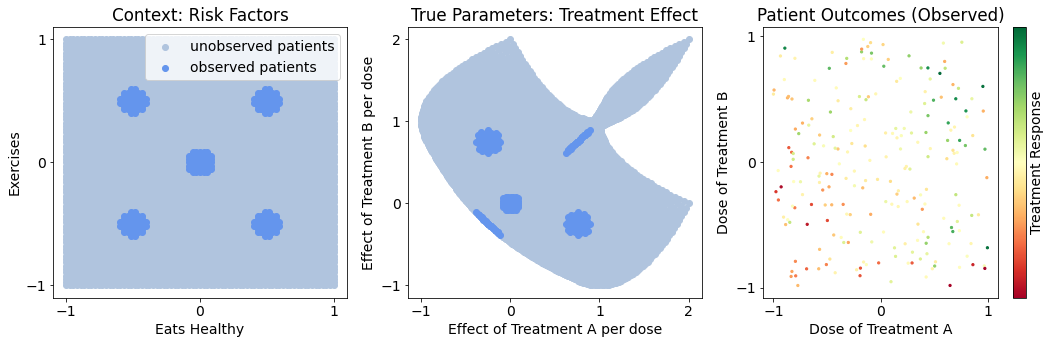

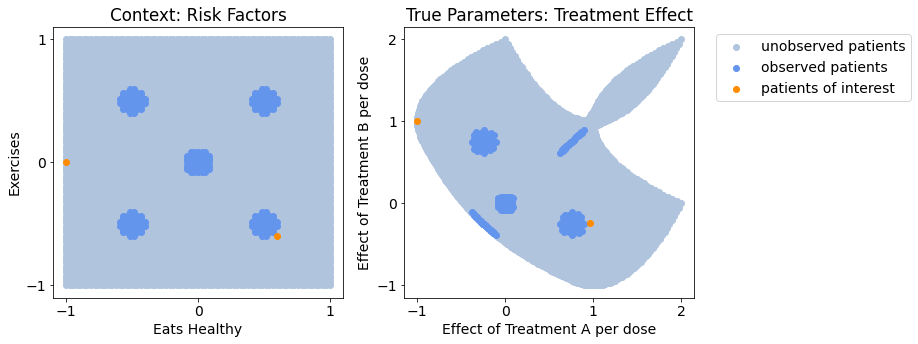

In [4]:
# Plot the observed and unobserved samples
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='unobserved patients')
axs[0].scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='observed patients')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')
axs[0].legend()

axs[1].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='unobserved patients')
axs[1].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='observed patients')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')

cplot = axs[2].scatter(X_train[:,0], X_train[:,1], c=cbar(Y_train), s=5., cmap='RdYlGn')
axs[2].set_xlabel('Dose of Treatment A')
axs[2].set_xticks([-1, 0, 1])
axs[2].set_ylabel('Dose of Treatment B')
axs[2].set_yticks([-1, 0, 1])
axs[2].set_title('Patient Outcomes (Observed)')
plt.colorbar(cplot, ax=axs[2], ticks=[], label='Treatment Response')
plt.tight_layout()
plt.show()


# Identify patients of interest
C_patients_pre = np.array([
    [.6, -.6],
    [-1, 0]
])
W_patients = np.zeros_like(C_patients_pre)
W_patients[:,0] = C_patients_pre[:,0] + C_patients_pre[:,1]**2 
W_patients[:,1] = C_patients_pre[:,0]**2 + C_patients_pre[:,1] 

C_patients = (C_patients_pre - C_mean) / C_std
X_patients = np.zeros_like(W_patients)
Y_patients = np.zeros((len(X_patients), 1))

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='unobserved')
axs[0].scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='observed')
axs[0].scatter(C_patients_pre[:,0], C_patients_pre[:,1], c='darkorange', label='patients of interest')
axs[0].set_xlabel('Eats Healthy')
axs[0].set_xticks([-1, 0, 1])
axs[0].set_ylabel('Exercises')
axs[0].set_yticks([-1, 0, 1])
axs[0].set_title('Context: Risk Factors')

axs[1].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='unobserved patients')
axs[1].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='observed patients')
axs[1].scatter(W_patients[:,0], W_patients[:,1], c='darkorange', label='patients of interest')
axs[1].set_xlabel('Effect of Treatment A per dose')
axs[1].set_xticks([-1, 0, 1, 2])
axs[1].set_ylabel('Effect of Treatment B per dose')
axs[1].set_yticks([-1, 0, 1, 2])
axs[1].set_title('True Parameters: Treatment Effect')
axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/patient_trueeffects.png', dpi=300)
plt.show()

### 1.4: Understanding the Problem

It is important to generalize to the unobserved areas because because these gaps often represent:

- Undersampled / underrepresented patient populations
- Undocumented / undiscovered treatments
- Rare cell types / diseases / risk factors

Let's pre-define our MSE evaluation metric and visualization

In [5]:
mse = lambda true, pred: ((true - pred)**2).mean()

def plot_all(w_hat, patient_w_hat, model_name):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))
    axs[0].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue')
    axs[0].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue')
    axs[0].scatter(w_hat[:,0], w_hat[:,1], c='crimson', label='predicted effects (all unobserved)')
    axs[0].set_xticks([-1, 0, 1])
    axs[0].set_yticks([-1, 0, 1])


    axs[1].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='true effects (unobserved patients)')
    axs[1].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='true effects (observed patients)')
    axs[1].scatter([], [], c='crimson', label='predicted effects (unobserved patients)')  # dummy plot for legend
    axs[1].scatter(W_patients[:,0], W_patients[:,1], c='darkorange', label='true effects (patients of interest)')
    axs[1].scatter(patient_w_hat[:,0], patient_w_hat[:,1], c='gold', label='predicted effects (patients of interest)')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.add_subplot(111, frameon=False)  # subplot axis hack
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Effect of treatment A per dose')
    axs[1].set_xticks([-1, 0, 1, 2])
    plt.ylabel('Effect of treatment B per dose')
    axs[1].set_yticks([-1, 0, 1, 2])
    plt.title('Model Parameters: Treatment Effects')
    plt.tight_layout()
#     plt.savefig(f'figures/{model_name}_effects.png', dpi=300)
    plt.show()

### 1.5: Approaching the Problem

We'll compare three approaches to modeling treatment response in this patient population:
- Population Regression: Disregard context, learn a single model for all patients
- Context-clustered Regression: We know context has some effect on model parameters, so cluster patients according to context and learn a model for each cluster
- Contextualized Regression: Learn the function from context to model parameters

For each of these models, we'll evaluate how well they recover the following in terms of MSE:
- True patient outcomes / treatment response
- True model parameters

In [6]:
# Define our models
from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ Y
        return self
        
    def predict_w(self, X):
        return np.tile(self.w.T, (len(X), 1))
    
    def predict_y(self, X):
        w_hat = self.predict_w(X)
        y_hat = (X * w_hat).sum(axis=1)[:, np.newaxis]
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.wdim = X.shape[-1]
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_l(self, C):
        return self.kmeans.predict(C)
    
    def predict_w(self, C, X):
        labels = self.predict_l(C)
        w_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            w_hat[l_idx] = self.models[label].predict_w(X_l)
        return w_hat
    
    def predict_y(self, C, X):
        labels = self.predict_l(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

### 1.6: Population Regression

In our initial pass we learn a single model from data, which turns out to be the average of all our true models.
This has terrible coverage of our model space, and completely disregards context. 

The predicted effects show how this model only learns a single general trend and ignores meaningful variation among patients.

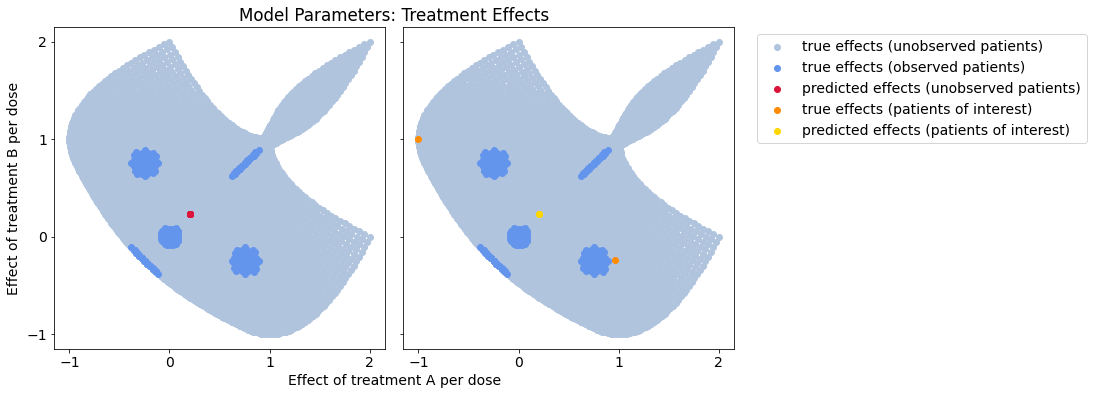

Treatment-response error: 	0.3108369566811793
Effect-size error: 		0.4610621463090046


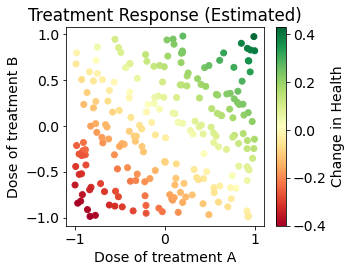

In [7]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)

w_hat = naive_model.predict_w(X_test)
patient_w_hat = naive_model.predict_w(X_patients)
y_hat = naive_model.predict_y(X_test)

plot_all(w_hat, patient_w_hat, 'population')
y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

plt.figure(figsize=(5.05,4))
plt.scatter(X_train[:,0], X_train[:,1], c=naive_model.predict_y(X_train), cmap='RdYlGn')
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Change in Health')
plt.title('Treatment Response (Estimated)')
plt.tight_layout()
# plt.savefig('figures/population_responses.png', dpi=300)
plt.show()

### 1.7: Context-clustered Regression

Context-clustering does much better on the unobserved patients than the population model, but we're severely constrained by the breadth of the data we've observed.
For the patient of interest near our observed data, this will work just fine.
However, with higher dimensional data the dataset coverage will always be sparse and new patients rarely match an observed population exactly.

Overall, we get very poor coverage of the overall parameter space, and our our outlier patient will have problems with her treatment.

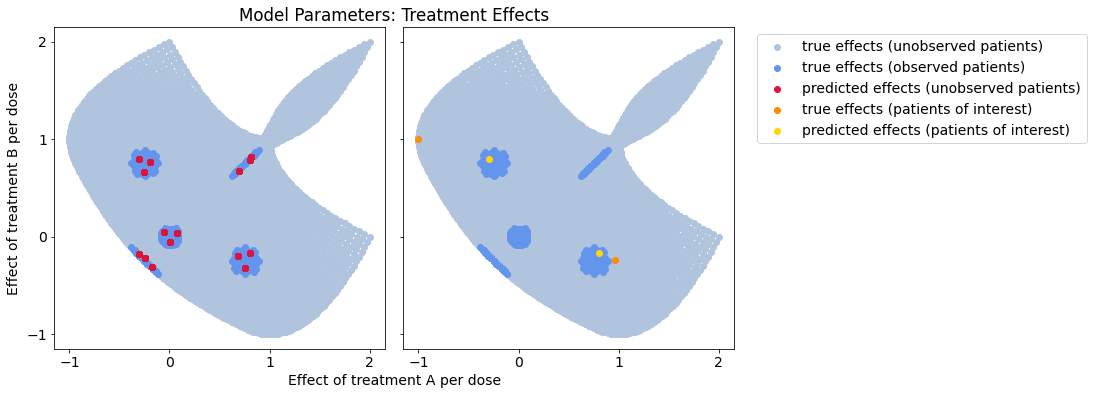

Treatment-response error: 	0.09760650633509192
Effect-size error: 		0.14512926781520713


In [8]:
# Cluster regression
cluster_model = ClusterRegression(15).fit(C_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)
patient_w_hat = cluster_model.predict_w(C_patients, X_patients)

plot_all(w_hat, patient_w_hat, 'cluster_neat')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

### 1.7: Context-clustered Regression with Noise

When we add noise parameters to the context, the cluster approach degrades. 
Because we're not estimating a function, it's difficult to do feature selection beyond 1st or 2nd order (1 or 2-feature) effects. 
Here, the coverage we get is due to noisy context and new samples will tend to align with the wrong clusters.

Clustering in this realistic case marginally improves on the population model.

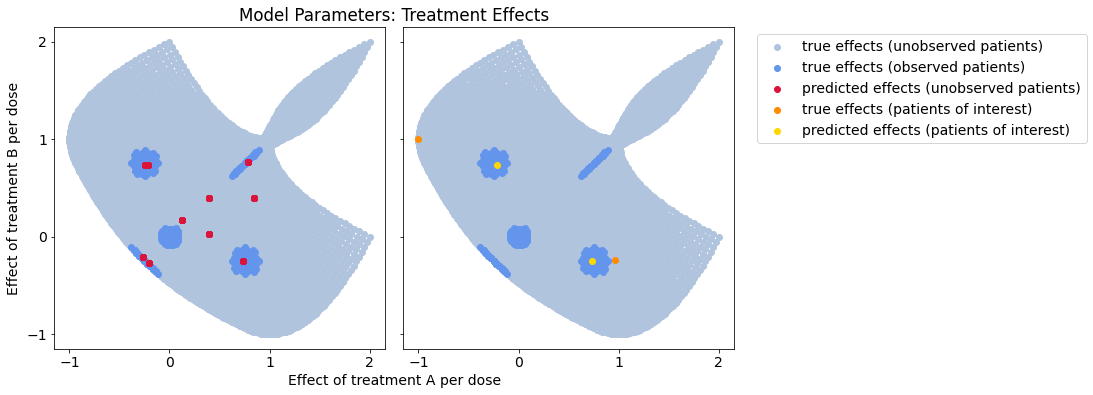

Response error: 0.14864557035778841
Effect-size error: 0.21798957793221288


In [9]:
# Regression from noise-context clustering
noise = np.random.normal(0, 1, (len(C), 2))
noise_train, noise_test = split(noise)
noise_mean, noise_std = noise_train.mean(axis=0), noise_train.std(axis=0)
noise_train = (noise_train - noise_mean) / noise_std
noise_test = (noise_test - noise_mean) / noise_std
C_noise_train = np.concatenate((C_train, noise_train), axis=-1)
C_noise_test = np.concatenate((C_test, noise_test), axis=-1)
C_noise_patients = np.concatenate((C_patients, noise_test[:len(C_patients)]), axis=-1)

cluster_model = ClusterRegression(10).fit(C_noise_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_noise_test, X_test)
y_hat = cluster_model.predict_y(C_noise_test, X_test)
patient_w_hat = cluster_model.predict_w(C_noise_patients, X_patients)

plot_all(w_hat, patient_w_hat, 'cluster_noisy')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

### 1.8: Contextualized Regression

Now let's learn the function from context to model parameters with our approach.
We get much better generalization and coverage of the parameter space by learning how context affects our models.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 1.0 K 
-----------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does n

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 221it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 221it [00:00, ?it/s]

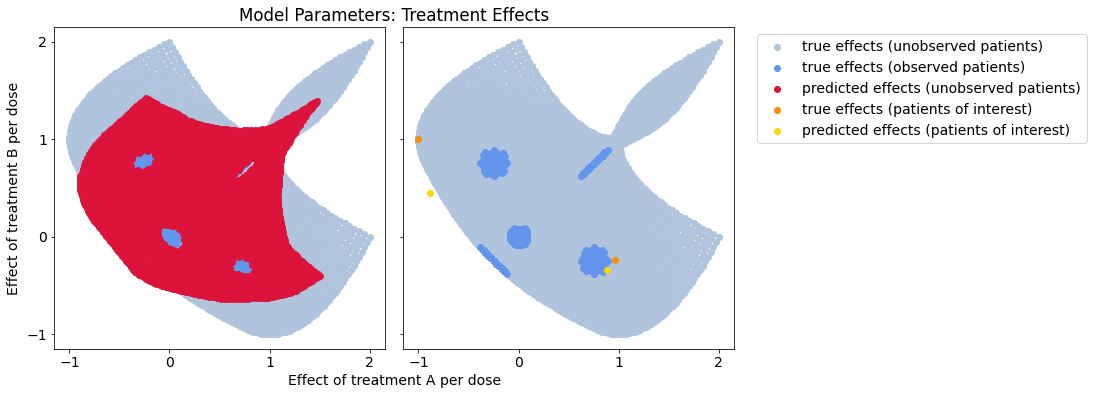

Response error: 0.025623551216621236
Effect-size error: 0.03768644460273578


In [10]:
# Regression from context encoding
encoder_kwargs = {'width': 25, 'layers': 2}
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=50, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

### 1.9: Contextualized Regression on Noise

For a quick sanity check, let's test what happens when we feed our context encoder __only__ noise. 
We see that for a completely uninformative context, we can do no worse than the population model.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 3.2 K 
-----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

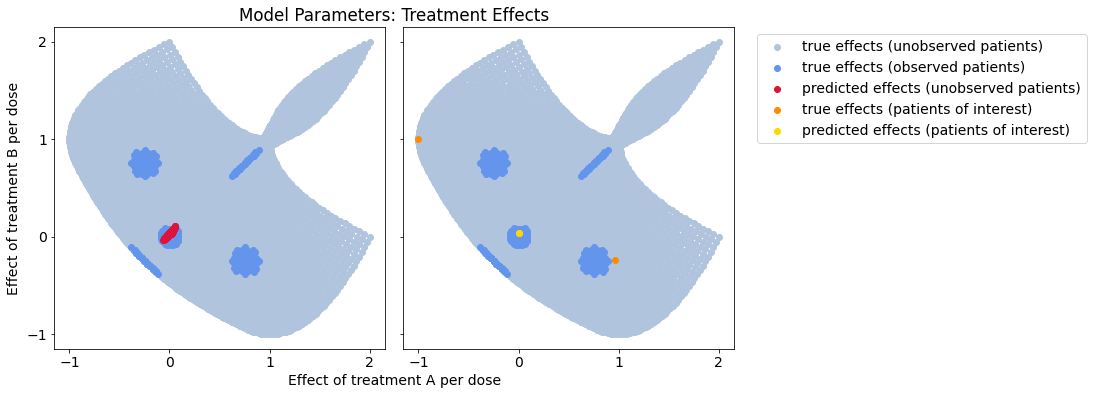

Response error: 0.37095633481978807
Effect-size error: 0.5509008456056914


In [11]:
# Regression from noise encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(noise_test[:len(C_patients)], X_patients, Y_patients, batch_size=1)
trainer = RegressionTrainer(max_epochs=2, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder_noise')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

### 1.9: Contextualized Regression with Some Noise

Now, we can use the context encoder to do automatic feature selection and knowledge distillation.
Because only some features are useful, the context encoder learns to use these over the noise features and produces a near-identical mapping as the contextualized regression with no noise in 1.7.

With interpretable deep learning frameworks like generalized additive models, we can discover the exact effect of each context feature on the model parameters.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 3.3 K 
-----------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

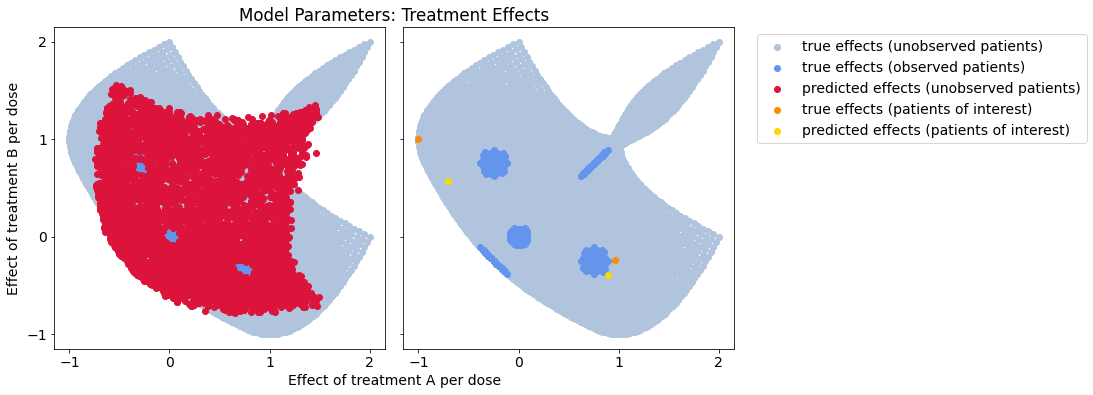

Response error: 0.036557982991450515
Effect-size error: 0.05450117370479259


In [12]:
# Regression from noisy context encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C_noise_train.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_noise_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=50, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder_somenoise')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

### 1.10: Throw a deep learner at it!

Given that our approach requires the use of a deep learner, it is natural to wonder whether the "secret sauce" here is our formulation or the deep learner itself.
Specificially, we believe our approach succeeds because it enforces an explicit representation of model parameters in the deep learner, but we can also see what happens when this explicit representation is removed.
For linear models, we can use the differentiability of neural networks to discover implicit representations of feature derivatives (i.e. linear model parameters)!

By training a standard multi-layer perceptron (neural network) to predict outcomes from context and dose, we can then use standard backpropagation to find the gradient of the outcome with respect to the dose features and infer the implicit parameters.

Below, you'll see that the implicit model representation is highly disorganized compared to our approach.
We believe this might be because our approach reduces the hypothesis space of potential models, requiring a much smaller sample complexity to learn.

/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_44824/1820882202.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_44824/1820882202.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_44824/1820882202.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_patients = torch.tensor(Y_patients, dtype=torch.flo

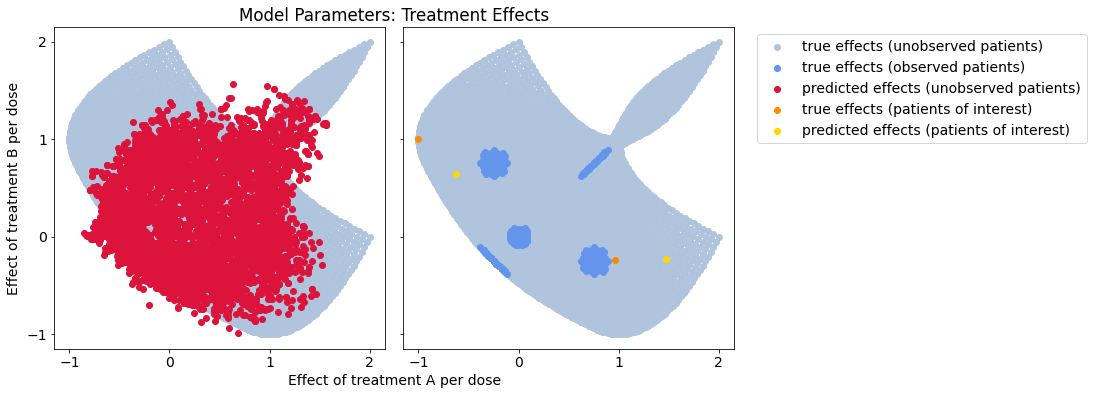

Response error: 0.04522298648953438
Effect-size error: 0.08997378498315811


In [14]:
# gradient models from MLP(CX) -> Y
from contextualized.modules import MLP

def get_grad(model, X):
    X.requires_grad = True
    for i in range(len(X)):
        yhat = model(X)
        yhat[i].backward()
    w_hat = X.grad.clone()
    X.requires_grad = False
    return w_hat

CX = torch.tensor(np.concatenate((C, X), axis=-1), dtype=torch.float32)
CX_patients = torch.tensor(np.concatenate((C_patients, X_patients), axis=-1), dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_patients = torch.tensor(Y_patients, dtype=torch.float32)

CX_train, CX_test = split(CX)
mlp = MLP(CX.shape[-1], Y.shape[-1], 50, 2)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
for _ in range(1000):
    loss = mse(mlp(CX_train), Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
train_w_hat_train = get_grad(mlp, CX_train)[:,-X.shape[-1]:]
test_w_hat = get_grad(mlp, CX_test)[:,-X.shape[-1]:]
patient_w_hat = get_grad(mlp, CX_patients)[:,-X_patients.shape[-1]:]
plot_all(test_w_hat, patient_w_hat, 'cx_mlp')

y_mse = mse(Y_test, mlp(CX_test))
w_mse = mse(torch.tensor(W_test, dtype=torch.float32), test_w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

## Section 2: Graphical Models

### 2.1: Problem Setup: Bayesian Networks
We take a similar approach here, simulating true Bayesian networks according to context and evaluating population, cluster, and contextualized network models in terms of how well they represent the samples they're assigned to (model MSE) and how close the estimated parameters are to the true parameters (parameter MSE). 

We use [NO-TEARS](https://arxiv.org/abs/1803.01422) to learn Bayesian networks with standard optimization libraries.

In [23]:
from pytorch_lightning import Trainer
from contextualized.dags.torch_notmad.callbacks import *
from contextualized.dags.torch_notmad.torch_notmad import NOTMAD_model
from contextualized.dags.torch_notmad.datamodules import CX_DataModule
from contextualized.dags.torch_notmad.baselines import BayesianNetwork, GroupedNetworks, project_all, dag_pred, mse_loss
from contextualized.dags.notmad_helpers.simulation import simulate_linear_sem
from sklearn.model_selection import train_test_split

dag_pred_torch = dag_pred
dag_pred = lambda a, b: dag_pred_torch(torch.Tensor(a), torch.Tensor(b))

In [17]:
from contextualized.dags.torch_notmad import baselines
import importlib
importlib.reload(baselines)
BayesianNetwork = baselines.BayesianNetwork
project_all = baselines.project_all

In [28]:
n = 1000
C = np.linspace(1, 2, n).reshape((n, 1))
# C = np.ones((n, 1))
blank = np.zeros_like(C)
W_00 = blank
W_01 = C-2
# W_01 = np.ones_like(C)
W_02 = blank
W_03 = blank
W_10 = blank
W_11 = blank
W_12 = blank
W_13 = blank
W_20 = blank
W_21 = C**2
W_22 = blank
W_23 = blank
W_30 = blank
W_31 = C**3
W_32 = C
W_33 = blank
W = np.array([
    [W_00, W_01, W_02, W_03],
    [W_10, W_11, W_12, W_13],
    [W_20, W_21, W_22, W_23],
    [W_30, W_31, W_32, W_33],
]).squeeze()
W = np.transpose(W, (2, 0, 1))
X = np.array([simulate_linear_sem(w, 1, 'gauss')[0] for w in W])

idx = np.logical_and(C > 1.7, C < 1.9).squeeze()
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
W_train, W_test = split(W)
C_train, C_test = split(C)
X_train, X_test = split(X)

### 2.2: Population Network

In [21]:
# Population Model
notears = BayesianNetwork().fit(X_train)

naive_preds_train = project_all(notears.predict(len(C_train)))
naive_preds = project_all(notears.predict(len(C_test)))
print(f"train L2:  {mse(naive_preds_train, W_train)}")
print(f"test L2:   {mse(naive_preds, W_test)}")
print(f"train MSE: {mse(dag_pred(X_train, naive_preds_train), X_train)}")
print(f"test MSE:  {mse(dag_pred(X_test, naive_preds), X_test)}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

train L2:  1.3724838544750515
test L2:   3.0590440372518835
train MSE: 18.546048868572086
test MSE:  33.94105493523884


### 2.3: Context-clustered Networks

In [22]:
# Cluster Model
kmeans = KMeans(n_clusters=10).fit(C_train)
train_cluster_labels = kmeans.predict(C_train)
test_cluster_labels = kmeans.predict(C_test)
clustered_model = GroupedNetworks(BayesianNetwork).fit(X_train, train_cluster_labels)

clustered_preds_train = project_all(clustered_model.predict(train_cluster_labels))
clustered_preds = project_all(clustered_model.predict(test_cluster_labels))
print(f"train L2: {mse(clustered_preds_train, W_train)}")
print(f"test L2:  {mse(clustered_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, clustered_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, clustered_preds), X_test)}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/contextualized/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

train L2: 1.337764663950752
test L2:  2.955198433559852
train mse: 18.238595738325053
test mse:  32.75662150642925


### 2.4: Contextualized Networks

In [34]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

torch.manual_seed(0)
np.random.seed(0)
C_train_sansval, C_val, X_train_sansval, X_val = train_test_split(C_train, X_train, test_size=0.2)
train_datamodule = CX_DataModule(C_train_sansval, X_train_sansval, batch_size=10)
val_datamodule = CX_DataModule(C_val, X_val, batch_size=100)
test_datamodule = CX_DataModule(C_test, X_test, batch_size=100)
contextualized_model = NOTMAD_model(
    train_datamodule,
    n_archetypes=10,
    encoder_type='mlp',
    encoder_kwargs={"width": 100, "layers": 3},
    sample_specific_loss_params={"l1": 1e-3, "alpha": 1e-1, "rho": 1e-2},
    archetype_loss_params={"l1": 0.0, "alpha": 1e-1, "rho": 1e-2},
    learning_rate=1e-3,
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", 
    dirpath=f'notmad_checkpoints',
    filename='{epoch}-{val_loss:.2f}'
)
es_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    verbose=True, 
    mode="min"
)
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
trainer = Trainer(max_epochs=100, auto_lr_find=True, accelerator=accelerator, devices=1, callbacks=[checkpoint_callback, es_callback])
trainer.fit(contextualized_model, train_datamodule)

# Get best checkpoint by val_loss, test and save
best_checkpoint = torch.load(checkpoint_callback.best_model_path)
contextualized_model.load_state_dict(best_checkpoint['state_dict'])

notmad_preds_train = project_all(contextualized_model(torch.Tensor(C_train)).detach().numpy())
notmad_preds = project_all(contextualized_model(torch.Tensor(C_test)).detach().numpy())
print(f"train L2: {mse(notmad_preds_train, W_train)}")
print(f"test L2:  {mse(notmad_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, notmad_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, notmad_preds), X_test)}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 21.4 K
1 | explainer | Explainer | 160   
----------------------------------------
21.6 K    Trainable params
0         Non-trainable params
21.6 K    Total params
0.086     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 84448792421.318


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18504142140.315 >= min_delta = 0.01. New best score: 65944650281.003


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 65944650281.003. Signaling Trainer to stop.


train L2: 0.14772663145951026
test L2:  0.23538885321683323
train mse: 1.7003540038703138
test mse:  1.488271120994366


### 2.4 Visualizing Networks
Use the code below to visualize true and predicted networks

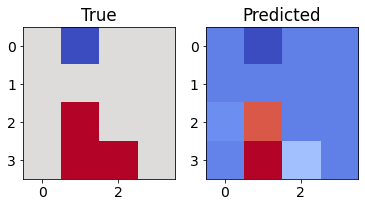

In [35]:
fig, axs = plt.subplots(1, 2)
i = 0
axs[0].imshow(W_train[i], cmap='coolwarm')
axs[0].set_title('True')
axs[1].imshow(notmad_preds_train[i], cmap='coolwarm')
axs[1].set_title('Predicted')
plt.show()